# Kaczmarek Kacper
Jakiś wstęp potem



---
# Procesowanie sygnału
#### 1. Zaciągnięcie danych z bazy https://physionet.org/content/gaitpdb/1.0.0/
#### 2. Zaczytanie danych
#### 3. Przedstawienie danych
---

### Zaczytanie danych

#### Zaczytanie metadanych

In [1]:
import pandas as pd
patients = pd.read_csv('Data/demographics.txt', sep='\\t')

C:\Users\Kaczmii\AppData\Local\Temp\ipykernel_16116\3240978679.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  patients = pd.read_csv('Data/demographics.txt', sep='\\t')


#### Zaczytanie danych o pacjentach

In [2]:
import utils

records = utils.readData()

### Prezentacja danych

#### Przykład zdrowego i chorego i rozkład sił na lewej i prawej stopie

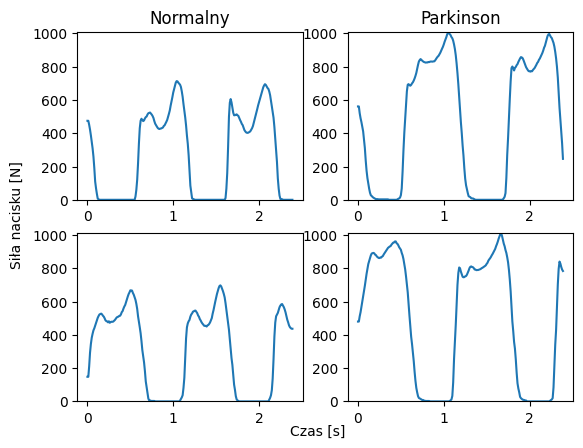

In [3]:
import matplotlib.pyplot as plt
import utils

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"
sample_number = 240

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

utils.createComparisonPlot(healthy_record, parkinson_record, sample_number)



#### Każdy czujnik dla zdrowego i chorego

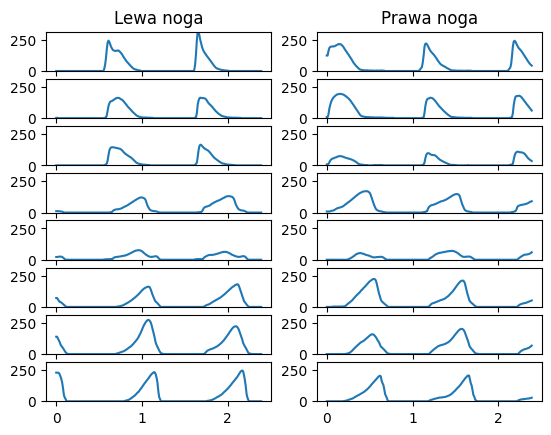

In [4]:
import utils
healthy_patient_id = "GaCo16"

healthy_record = records[healthy_patient_id]["data1"]

utils.createAllSensorPlot(healthy_record, 'healthy_all_sensors', sample_number)

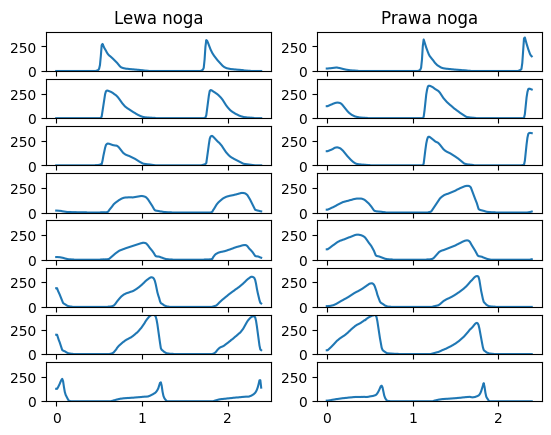

In [5]:
import utils
parkinson_patient_id = "GaPt26"

parkinson_record = records[parkinson_patient_id]["data1"]

utils.createAllSensorPlot(parkinson_record, 'parkinson_all_sensors', sample_number)

#### Wyliczenie najmniejszej porcji danych chodu

In [6]:
sample_len = float("inf")
for key, value in records.items():
    record = value['data1']
    sample_len = min(len(record.Time), sample_len)

print(sample_len)

4034


### Pokazanie zachowań kroków na podstawie czujnika prawej stopy

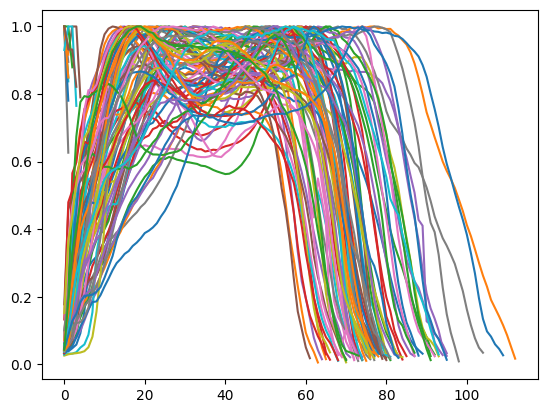

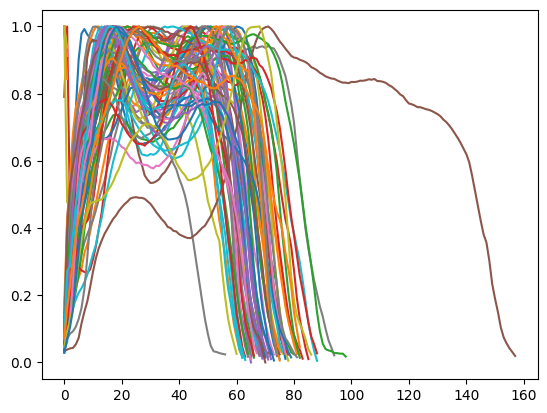

In [7]:
steps = {}
minVal = 30
for key, value in records.items():
    record = value['data1']
    idx = record.index[record.Force_Right < minVal].tolist()[0] + 1
    start = record[idx:].index[record.Force_Right[idx:] > minVal].tolist()[0]
    end = record[start:].index[record[start:].Force_Right < minVal].tolist()[0]
    step = record.Force_Right[start:end+1].tolist()
    steps[key] = [x / max(step) for x in step]

parkinsons = []
healthys = []
for key in steps:
    hoehnYahr = patients[patients['ID'] == key]['HoehnYahr'].values[0]
    parkinsons.append(key) if hoehnYahr > 0 else healthys.append(key)
    

plt.figure()
for key in parkinsons:
    plt.plot(steps[key])
plt.show()

plt.figure()
for key in healthys:
    plt.plot(steps[key])
plt.show()

152


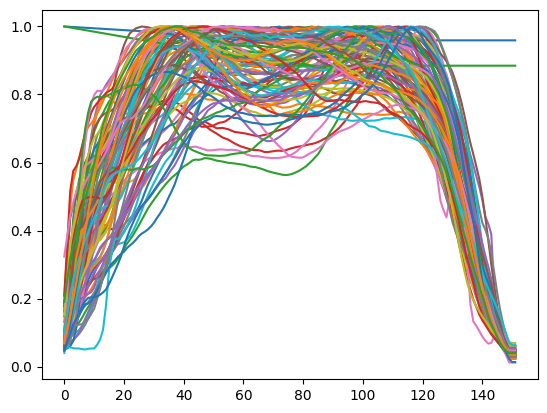

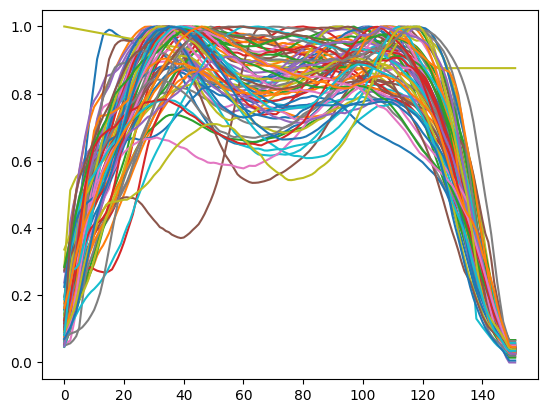

In [8]:
import numpy as np
steps = {}
minVal = 50
maxStep = float("-inf")
for key, value in records.items():
    record = value['data1']
    idx = record.index[record.Force_Right < minVal].tolist()[0] + 1
    start = record[idx:].index[record.Force_Right[idx:] > minVal].tolist()[0]
    end = record[start:].index[record[start:].Force_Right < minVal].tolist()[0]
    step = record.Force_Right[start:end+1].tolist()
    maxStep = max(maxStep, len(step))
    steps[key] = [x / max(step) for x in step]
print(maxStep)
def rescale(arr, maxStep):
    n = len(arr)
    return np.interp(np.linspace(0, n, maxStep), np.arange(n), arr)
parkinsons = []
healthys = []
for key in steps:
    hoehnYahr = patients[patients['ID'] == key]['HoehnYahr'].values[0]
    parkinsons.append(key) if hoehnYahr > 0 else healthys.append(key)
    

plt.figure()
for key in parkinsons:
    plt.plot(rescale(steps[key], maxStep))
plt.show()

plt.figure()
for key in healthys:
    plt.plot(rescale(steps[key], maxStep))
plt.show()

### Porównanie podczas liczenia do 7 w dół

128


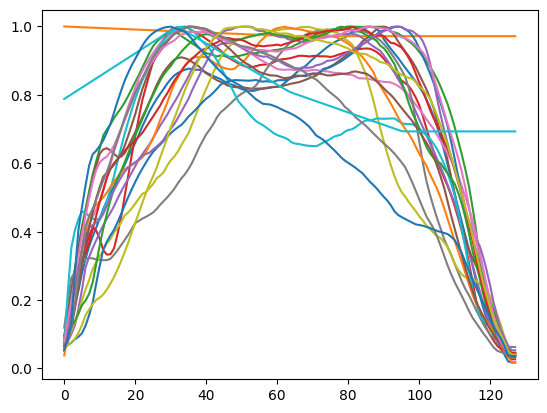

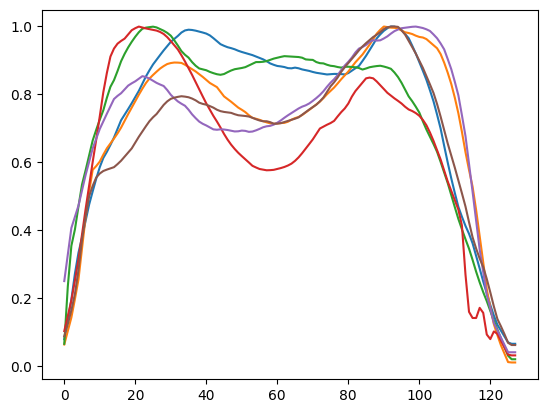

In [9]:
import numpy as np
steps = {}
minVal = 50
maxStep = float("-inf")
for key, value in records.items():
    if key.startswith('Ga') and 'data10' in value.keys():
        record = value['data10']
        idx = record.index[record.Force_Right < minVal].tolist()[0] + 1
        start = record[idx:].index[record.Force_Right[idx:] > minVal].tolist()[0]
        end = record[start:].index[record[start:].Force_Right < minVal].tolist()[0]
        step = record.Force_Right[start:end+1].tolist()
        maxStep = max(maxStep, len(step))
        steps[key] = [x / max(step) for x in step]
print(maxStep)
def rescale(arr, maxStep):
    n = len(arr)
    return np.interp(np.linspace(0, n, maxStep), np.arange(n), arr)
parkinsons = []
healthys = []
for key in steps:
    hoehnYahr = patients[patients['ID'] == key]['HoehnYahr'].values[0]
    parkinsons.append(key) if hoehnYahr > 0 else healthys.append(key)
    

plt.figure()
for key in parkinsons:
    plt.plot(rescale(steps[key], maxStep))
plt.show()

plt.figure()
for key in healthys:
    plt.plot(rescale(steps[key], maxStep))
plt.show()

#### Prezentacja typów falek

D:\Studia\Parkinson\venv\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


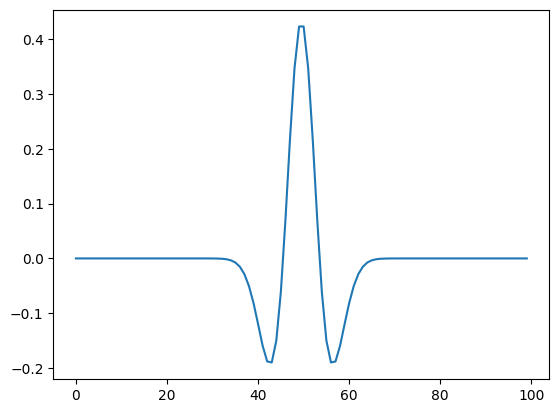

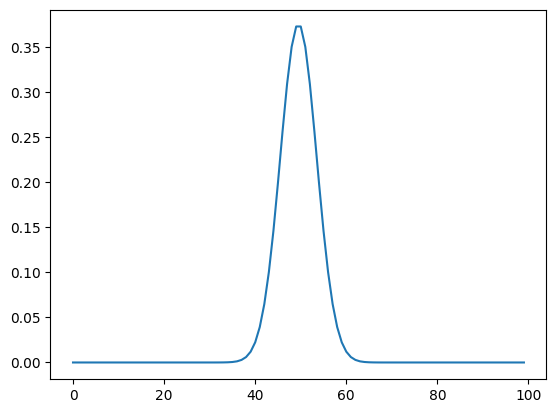

In [10]:
from scipy import signal
import matplotlib.pyplot as plt


points = 100
a = 4
w = 0

plt.figure()
vec_ricker = signal.ricker(points, a)
plt.plot(vec_ricker)

plt.savefig("plots/wavelet-type-ricker.pdf", format="pdf", bbox_inches="tight")

plt.figure()
vec_morlet2 = signal.morlet2(points, a, w)
plt.plot(vec_morlet2)

plt.savefig("plots/wavelet-type-morlet.pdf", format="pdf", bbox_inches="tight")


#### Wykresy transfomaty falkowej

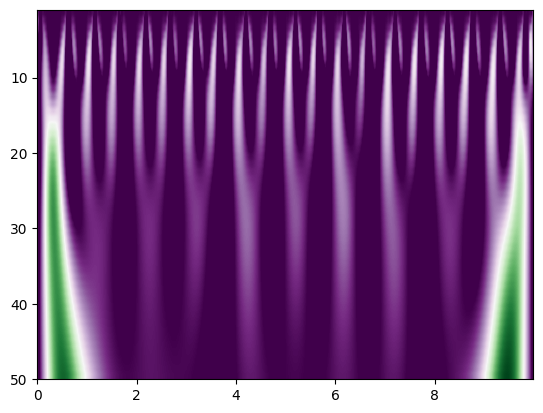

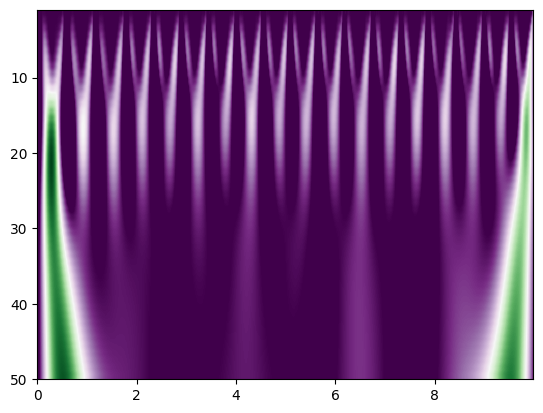

In [11]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]
parkinson_record = records[parkinson_patient_id]["data1"]

sample_number = 1000

y_healthy = healthy_record.Force_Left.head(sample_number) - healthy_record.Force_Right.head(sample_number)
y_healthy = y_healthy.abs()
x_healthy = healthy_record.Time.head(sample_number)

y_parkinson = parkinson_record.Force_Left.head(sample_number) - parkinson_record.Force_Right.head(sample_number)
y_parkinson = y_parkinson.abs()
x_parkinson = parkinson_record.Time.head(sample_number)

width = 50
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=abs(cwtmatr).min())
plt.savefig("plots/healthy-wavelet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_parkinson, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_parkinson.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=abs(cwtmatr).min())
plt.savefig("plots/parkinson-wavelet.pdf", format="pdf", bbox_inches="tight")

Porównanie tranformaty falkowej morleta i rickera

D:\Studia\Parkinson\venv\lib\site-packages\scipy\signal\_wavelets.py:470: ComplexWarning: Casting complex values to real discards the imaginary part
  output[ind] = convolve(data, wavelet_data, mode='same')


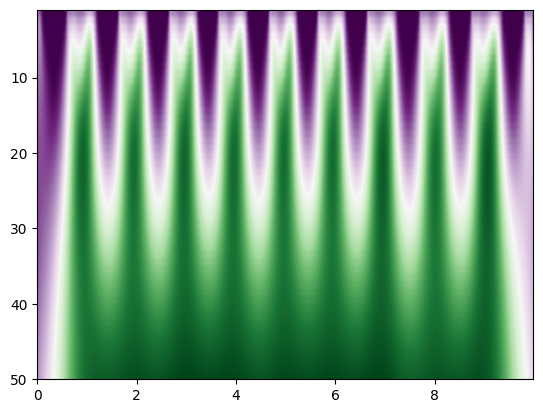

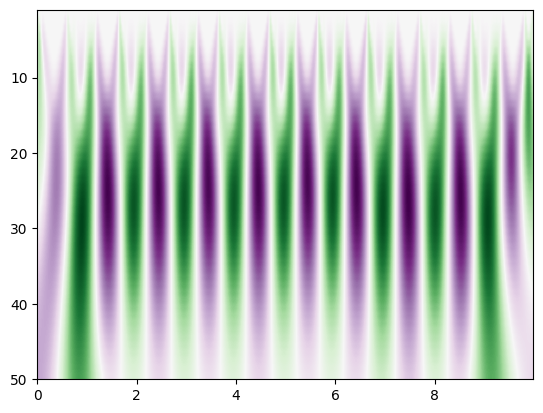

In [12]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

healthy_patient_id = "GaCo16"
parkinson_patient_id = "GaPt26"

healthy_record = records[healthy_patient_id]["data1"]

# sample_number = 4034
sample_number = 1000

y_healthy = healthy_record.Force_Left.head(sample_number)
x_healthy = healthy_record.Time.head(sample_number)

width = 50

w = 0
widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.morlet2, widths, dtype='float64', w=w)

plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=cwtmatr.max(), vmin=cwtmatr.min())
plt.savefig("plots/healthy-morlet.pdf", format="pdf", bbox_inches="tight")

widths = np.arange(1, width)
cwtmatr = signal.cwt(y_healthy, signal.ricker, widths, dtype='float64')
plt.figure()
plt.imshow(cwtmatr, extent=[0, x_healthy.values[-1], width, 1], cmap='PRGn', aspect='auto', vmax=cwtmatr.max(), vmin=cwtmatr.min())
plt.savefig("plots/healthy-ricker.pdf", format="pdf", bbox_inches="tight")

### Klasyfikacja

#### Tworzenie obrazów do klasyfikacji

In [13]:
cond = False
if cond:
    width = 40
    widths = np.arange(1, width)
    sample_number = 4034
    splits = 4
    w = 0.0
    for id, value in records.items():
        print(f'Processing ID = {id}')
        hoehnYahr = patients[patients['ID'] == id]['HoehnYahr'].values[0]
        parkinson = 'Parkinson' if hoehnYahr > 0 else 'Healthy'
        hoehnYahr = hoehnYahr if hoehnYahr > 0 else 0.0

        sensors = [
            (lambda x: x.L1, "L1"),
            (lambda x: x.L2, "L2"),
            (lambda x: x.L3, "L3"),
            (lambda x: x.L4, "L4"),
            (lambda x: x.L5, "L5"),
            (lambda x: x.L6, "L6"),
            (lambda x: x.L7, "L7"),
            (lambda x: x.L8, "L8"),
            # (lambda x: x.Force_Left, "Force_Left"),
            (lambda x: x.R1, "R1"),
            (lambda x: x.R2, "R2"),
            (lambda x: x.R3, "R3"),
            (lambda x: x.R4, "R4"),
            (lambda x: x.R5, "R5"),
            (lambda x: x.R6, "R6"),
            (lambda x: x.R7, "R7"),
            (lambda x: x.R8, "R8"),
            # (lambda x: x.Force_Right, "Force_Right")
            ]
        record = value['data1']

        splits_list = [i for i in range(0, sample_number*(splits+1)//splits, sample_number//splits)]

        for sensor in sensors:
            for i in range(1, len(splits_list)):
                func, name = sensor
                x = record.Time[splits_list[i-1]:splits_list[i]]
                y = func(record)[splits_list[i-1]:splits_list[i]]
                # cwtFunc = lambda: signal.cwt(y, signal.morlet2, widths, dtype='float64', w=w)
                cwtFunc = lambda: signal.cwt(y, signal.ricker, widths, dtype='float64')
                utils.createWaveletPlot(x, cwtFunc, parkinson, id, f'{name}_{i}')
                # utils.createWaveletPlot(x, cwtFunc, hoehnYahr, id, f'{name}_{i}')

In [14]:
cond = False
if cond:
    width = 50
    widths = np.arange(1, width)
    howManyInSample = 500
    w = 0.0
    for id, value in records.items():
        print(f'Processing ID = {id}')
        hoehnYahr = patients[patients['ID'] == id]['HoehnYahr'].values[0]
        parkinson = 'Parkinson' if hoehnYahr > 0 else 'Healthy'
        hoehnYahr = hoehnYahr if hoehnYahr > 0 else 0.0

        sensors = [
            # (lambda x: x.L1, "L1"),
            # (lambda x: x.L2, "L2"),
            # (lambda x: x.L3, "L3"),
            # (lambda x: x.L4, "L4"),
            # (lambda x: x.L5, "L5"),
            # (lambda x: x.L6, "L6"),
            # (lambda x: x.L7, "L7"),
            # (lambda x: x.L8, "L8"),
            (lambda x: x.Force_Left - x.Force_Right, "Force_Left"),
            # (lambda x: x.R1, "R1"),
            # (lambda x: x.R2, "R2"),
            # (lambda x: x.R3, "R3"),
            # (lambda x: x.R4, "R4"),
            # (lambda x: x.R5, "R5"),
            # (lambda x: x.R6, "R6"),
            # (lambda x: x.R7, "R7"),
            # (lambda x: x.R8, "R8"),
            # (lambda x: x.Force_Right, "Force_Right")
            ]
        record = value['data1']

        splits_list = [i for i in range(0, len(record), howManyInSample)]

        for sensor in sensors:
            for i in range(1, len(splits_list)):
                func, name = sensor
                start = splits_list[i-1]
                end = splits_list[i]
                if end - start == howManyInSample:
                    x = record.Time[start:end]
                    y = func(record).abs()[start:end]
                    # cwtFunc = lambda: signal.cwt(y, signal.morlet2, widths, dtype='float64', w=w)
                    cwtFunc = lambda: signal.cwt(y, signal.ricker, widths, dtype='float64')
                    utils.createWaveletPlot(x, cwtFunc, parkinson, id, f'{name}_{i}')
                    # utils.createWaveletPlot(x, cwtFunc, hoehnYahr, id, f'{name}_{i}')

#### Przygotowanie zbiorów danych

In [15]:
import csv
import os
import pickle

cond = True
if cond:
    type = "Binary"
    wavelet = "Ricker"
    directory = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    output = f"{os.getcwd()}/Datasets/{type}/{wavelet}"
    split = "70/20/10"
    
    train_f = open(f"{output}_train", 'w', encoding='UTF8', newline='')
    train_writer = csv.writer(train_f)
    test_f = open(f"{output}_test", 'w', encoding='UTF8', newline='')
    test_writer = csv.writer(test_f)
    validation_f = open(f"{output}_validation", 'w', encoding='UTF8', newline='')
    validation_writer = csv.writer(validation_f)

    s = split.split('/')
    splits = {
        "train": int(s[0]),
        "test": int(s[1]),
        "validation": int(s[2])
    }

    classes = {}
    for idx, c in enumerate(os.listdir(directory)):
        classes[idx] = c

        images = os.listdir(f"{directory}/{c}")
        class_count = len(images)
        for imidx, filename in enumerate(images):
            row = [f"{c}/{filename}", idx]
            if imidx < class_count * splits["train"] / 100:
                train_writer.writerow(row)
            elif imidx < class_count * (splits["train"] + splits["test"]) / 100:
                test_writer.writerow(row)
            else:
                validation_writer.writerow(row)

    with open(f"{output}_utils", 'wb') as f:
        pickle.dump(classes, f)

    train_f.close()
    test_f.close()
    validation_f.close()

#### Uczenie sieci

Epoch 0/149
----------
train Loss: 0.7024 Acc: 0.5715
val Loss: 0.7661 Acc: 0.4127

Epoch 1/149
----------
train Loss: 0.6526 Acc: 0.6105
val Loss: 0.7285 Acc: 0.5392

Epoch 2/149
----------
train Loss: 0.6493 Acc: 0.6078
val Loss: 0.7954 Acc: 0.4209

Epoch 3/149
----------
train Loss: 0.6429 Acc: 0.6197
val Loss: 0.7696 Acc: 0.4512

Epoch 4/149
----------
train Loss: 0.6425 Acc: 0.6091
val Loss: 0.7931 Acc: 0.4429

Epoch 5/149
----------
train Loss: 0.6323 Acc: 0.6172
val Loss: 0.7918 Acc: 0.4319

Epoch 6/149
----------
train Loss: 0.6333 Acc: 0.6277
val Loss: 0.8127 Acc: 0.3920

Epoch 7/149
----------
train Loss: 0.6310 Acc: 0.6172
val Loss: 0.8003 Acc: 0.4746

Epoch 8/149
----------
train Loss: 0.6265 Acc: 0.6275
val Loss: 0.8355 Acc: 0.4044

Epoch 9/149
----------
train Loss: 0.6263 Acc: 0.6270
val Loss: 0.7960 Acc: 0.4360

Epoch 10/149
----------
train Loss: 0.6219 Acc: 0.6305
val Loss: 0.8021 Acc: 0.5062

Epoch 11/149
----------
train Loss: 0.6186 Acc: 0.6395
val Loss: 0.7922 Acc

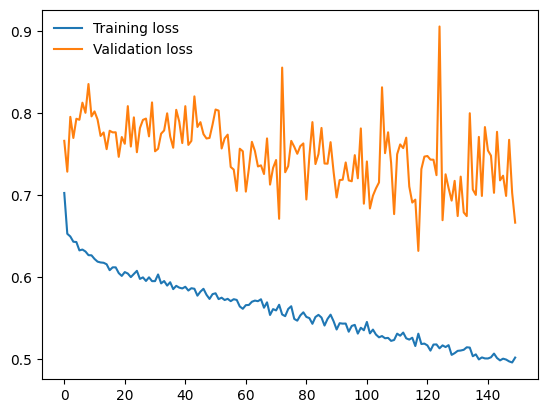

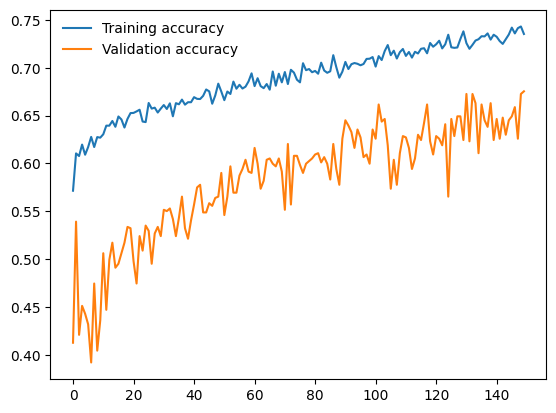

Test dataset Accuracy: 0.6728395061728395
Test dataset Confusion_matrix 
 [[314. 300.]
 [177. 667.]]


<Figure size 640x480 with 0 Axes>

In [16]:
import LearningUtils
import importlib
import os
import ModelTrainer
from torchvision import models
from torchsummary import summary
importlib.reload(ModelTrainer)
importlib.reload(LearningUtils)

cond = True
if cond:
    imgdir = f"{os.getcwd()}/Datasets/Binary/Ricker"

    classes = LearningUtils.get_classes(imgdir)
    train_data_loader, validation_data_loader, test_data_loader = LearningUtils.prepare_data(imgdir)
    model_trainer = ModelTrainer.ModelTrainer(classes)
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # summary(resnet, (3, 224, 224))
    model = model_trainer.train_resnet(resnet, train_data_loader, validation_data_loader, num_epochs=250)
    model.eval()
    LearningUtils.predict_image(model, test_data_loader, classes)